In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
from IPython.display import clear_output, Image, display
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
from tf_conversions import posemath

In [2]:
rospy.init_node('notebook')

In [3]:
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/position_cartesian_desired', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM1/status', 'std_msgs/String'],
 ['/dvrk/console/teleop/scale', 'std_msgs/Float32'],
 ['/dvrk/tf_br

In [4]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_flipped', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_flipped', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnU3RvcCcsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCkpLCBPdXRwdXQobGF5b3V0PUxheW91dChib3JkZXLigKY=


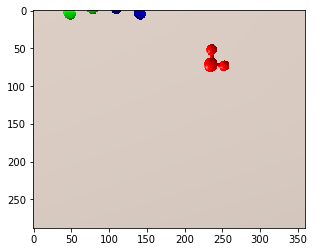

In [5]:
left_image = cv2.flip(left_image, 0)
plt.imshow(left_image)

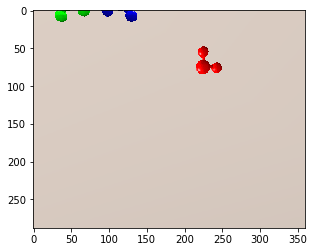

In [6]:
right_image = cv2.flip(right_image, 0)
plt.imshow(right_image)

In [7]:
print("LEFT CAM")
print(left_camera_info)
print("RIGHT_CAM")
print(right_camera_info)

LEFT CAM
header: 
  seq: 417
  stamp: 
    secs: 1589573677
    nsecs: 199120998
  frame_id: "left_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: True
RIGHT_CAM
header: 
  seq: 404
  stamp: 
    secs: 1589573676
    nsecs: 144664764
  frame_id: "right_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, -1.5598017585329753, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_

In [8]:
psm1 = None 
ecm = None
suj = None
debug_output = widgets.Output(layout={'border': '1px solid black'})

with debug_output:
    global psm1, ecm
    psm1 = dvrk.psm('PSM1')
    ecm = dvrk.ecm('ECM')
    suj = dvrk.suj('ECM')


In [9]:
psm1.get_current_position()

[[           1,-8.86787e-06,  7.3459e-06;
   1.1465e-05,    0.707179,   -0.707035;
  1.07503e-06,    0.707035,    0.707179]
[     1.95011,  -0.0927632,    -0.87215]]

In [10]:
ecm.get_current_position()

[[          -1,-6.27083e-06,-6.27028e-06;
  -8.8679e-06,    0.707179,    0.707035;
  5.09929e-10,    0.707035,   -0.707179]
[ 2.93028e-06,    0.580657,    0.244121]]

In [11]:
suj.get_current_position()

[[          -1, 6.27081e-06, 2.59709e-06;
 -6.27081e-06,   -0.707176,   -0.707037;
 -2.59709e-06,   -0.707037,    0.707176]
[  3.6871e-06,    0.495318,    0.329477]]

In [12]:
tf_listener = tf.TransformListener()

In [13]:
tf_listener.getFrameStrings()

/opt/ros/melodic/lib/python2.7/dist-packages/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['PSM2_tool_wrist_shaft_link',
 'PSM2_outer_pitch_front_link',
 'PSM2_tool_main_link',
 'PSM2_tool_wrist_caudier_link_2_left',
 'PSM1',
 'PSM2',
 'PSM2_tool_wrist_caudier_ee_link',
 'PSM2_outer_insertion_link',
 'PSM1_tool_wrist_sca_ee_link_2',
 'ecm_setup_link',
 'ecm_yaw_link',
 'PSM2_tool_wrist_caudier_link_shaft',
 'PSM1_tool_wrist_sca_ee_link_0',
 'ECM',
 'PSM1_outer_pitch_link',
 'PSM2_base',
 'PSM2_outer_pitch_link',
 'PSM1_tool_tip_link',
 'camera',
 'PSM1_tool_wrist_sca_ee_link_1',
 'PSM1_outer_pitch_front_link',
 'ecm_pitch_link',
 'PSM1_outer_pitch_top_link',
 'PSM2_tool_wrist_caudier_link',
 'PSM1_outer_yaw_link',
 'ecm_roll_link',
 'ecm_pitch_link_2',
 'ecm_pitch_link_3',
 'PSM1_tool_wrist_shaft_link',
 'PSM2_outer_pitch_back_link',
 'PSM1_tool_wrist_sca_link',
 'PSM2_outer_pitch_top_link',
 'PSM3_base',
 'PSM2_tool_wrist_caudier_ee_link_0',
 'PSM1_outer_insertion_link',
 'PSM2_outer_pitch_bottom_link',
 'ECM_base',
 'ecm_insertion_link',
 'PSM1_outer_pitch_bottom_link',
 

[INFO] [1589573683.710205]: Number of feature files:
[INFO] [1589573683.718970]: 1
[INFO] [1589573683.728604]: Feature ranges: 
[INFO] [1589573683.735222]: [[[  0.  37.  45.]
  [ 23. 100. 100.]]]
[INFO] [1589573683.751730]: 0
[INFO] [1589573683.754454]: Size: 31.25699921617557
[INFO] [1589573683.757406]: Height: 288 Width: 360
[INFO] [1589573683.768999]: [x: 242.0
y: 223.0]
[INFO] [1589573683.771258]: [[242. 223.]]
[INFO] [1589573683.777325]: Size: 0.0
[INFO] [1589573683.779932]: Height: 288 Width: 360
[INFO] [1589573683.784095]: [x: 232.0
y: 220.0]
[INFO] [1589573683.788582]: [[232. 220.]]
[INFO] [1589573683.791107]: Size: 0.0
type: 
  data: "centroids"
center: 
  x: 242
  y: 223
zoom: 
  data: 1.0
yaw_angle: 
  data: 0.0
points: 
  - 
    x: 242.0
    y: 223.0


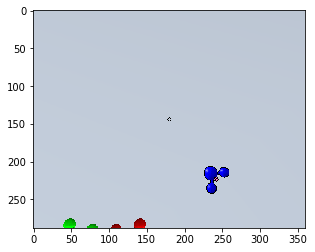

In [14]:
import image_geometry
import vision_pipeline
BALL_FEAT_PATH = '../autonomous_surgical_camera/auto_cam/config/features/red_ball.csv'
cv2.imwrite('left.png', left_image)
fp = vision_pipeline.feature_processor([BALL_FEAT_PATH], 'left.png')
left_feats, left_frame = fp.Centroids(left_image_msg)
right_feats, right_frame = fp.Centroids(right_image_msg)
print(left_feats)
plt.imshow(left_frame)

type: 
  data: "centroids"
center: 
  x: 232
  y: 220
zoom: 
  data: 1.0
yaw_angle: 
  data: 0.0
points: 
  - 
    x: 232.0
    y: 220.0


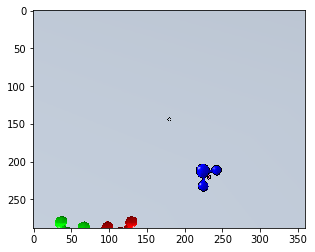

In [15]:
print(right_feats)
plt.imshow(right_frame)

[(242.0, 223.0)]
[(232.0, 220.0)]


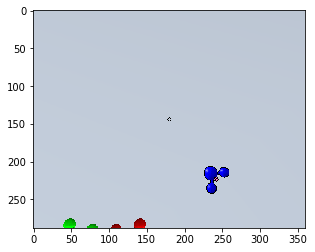

In [16]:
left_cam = image_geometry.PinholeCameraModel()
left_cam.fromCameraInfo(left_camera_info)
right_cam = image_geometry.PinholeCameraModel()
right_cam.fromCameraInfo(right_camera_info)
left_frame_rectified = deepcopy(left_frame)

def rectify(cam, ros_pt):
    return tuple(cam.rectifyPoint((ros_pt.x, ros_pt.y)))

def invert_rectify(cam, ros_pt, frame_dims):
    return tuple(cam.rectifyPoint((frame_dims[0] - ros_pt.x, frame_dims[1] - ros_pt.y)))

left_feat_pts = [rectify(left_cam, pt) for pt in left_feats.points]
right_feat_pts = [rectify(right_cam, pt) for pt in right_feats.points]
print(left_feat_pts)
print(right_feat_pts)
left_cam.rectifyImage(left_frame, left_frame_rectified)
plt.imshow(left_frame)

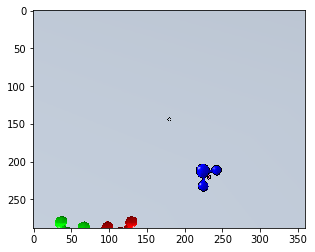

In [17]:
right_frame_rectified = deepcopy(right_frame)
left_cam.rectifyImage(right_frame, right_frame_rectified)
plt.imshow(right_frame_rectified)

In [18]:
stereocam = image_geometry.StereoCameraModel()
stereocam.fromCameraInfo(left_camera_info, right_camera_info)
disparity = abs(left_feat_pts[0][0] - right_feat_pts[0][0])
print(disparity)
ball_pos_cam = stereocam.projectPixelTo3d(left_feat_pts[0], disparity)
print(ball_pos_cam)

10.0
(0.031, 0.0395, 0.15598017585329754)


In [19]:
def tfl_to_pykdl_frame(tfl_frame):
    pos, rot_quat = tfl_frame
    pos2 = PyKDL.Vector(*pos)
    rot = PyKDL.Rotation.Quaternion(*rot_quat)
    return PyKDL.Frame(rot, pos2)

In [20]:
ball_pos_cam = PyKDL.Vector(*ball_pos_cam)

In [21]:
# some hardcoded transforms from suj-simulated.json
ECM_WORLD_ORIGIN_TO_SUJ_ROT_MAT = np.asarray([[ 0.0000,  -1.0000,  0.0000],
                                              [1.0000,  0.0000,  0.0000],
                                              [ 0.0000,  0.0000,  1.0000]])
ECM_WORLD_ORIGIN_TO_SUJ_ROT = PyKDL.Rotation(*ECM_WORLD_ORIGIN_TO_SUJ_ROT_MAT.flatten())
ECM_WORLD_ORIGIN_TO_SUJ_TRANS = PyKDL.Vector(0.0000 , 0.0000, 0.4300)
ECM_WORLD_ORIGIN_TO_SUJ_FRAME = PyKDL.Frame(ECM_WORLD_ORIGIN_TO_SUJ_ROT, ECM_WORLD_ORIGIN_TO_SUJ_TRANS)
ECM_SUJ_TO_WORLD_ORIGIN_FRAME = ECM_WORLD_ORIGIN_TO_SUJ_FRAME.Inverse()

ECM_SUJ_TO_BASE_ROT_MAT = np.asarray([[ 0.0000, 1.0000,  0.0000],
                                      [ -1.0000,  0.0000,  0.0000],
                                      [ 0.0000,  0.0000,  1.0000]])
ECM_SUJ_TO_BASE_ROT = PyKDL.Rotation(*ECM_BASE_TO_SUJ_ROT_MAT.flatten())
ECM_SUJ_TO_BASE_TRANS = PyKDL.Vector(0.6126, 0.0000,   0.1016)
ECM_SUJ_TO_BASE_FRAME = PyKDL.Frame(ECM_BASE_TO_SUJ_ROT, ECM_BASE_TO_SUJ_TRANS)
ECM_BASE_TO_SUJ_FRAME = ECM_SUJ_TO_BASE_FRAME.Inverse()

ECM_BASE_TO_WORLD_FRAME = 

PSM1_WORLD_ORIGIN_TO_SUJ_ROT_MAT = np.asarray([[-1.0000,  0.0000,  0.0000],
                                               [ 0.0000, -1.0000,  0.0000],
                                               [ 0.0000,  0.0000,  1.0000]])
PSM1_WORLD_ORIGIN_TO_SUJ_ROT = PyKDL.Rotation(*PSM1_WORLD_ORIGIN_TO_SUJ_ROT_MAT.flatten())
PSM1_WORLD_ORIGIN_TO_SUJ_TRANS = PyKDL.Vector(0.4864, 0.0000, 0.1524)
PSM1_WORLD_ORIGIN_TO_SUJ_FRAME = PyKDL.Frame(PSM1_WORLD_ORIGIN_TO_SUJ_ROT, PSM1_WORLD_ORIGIN_TO_SUJ_TRANS)

PSM1_SUJ_TO_TOOL_ROT_MAT = np.asarray([[ 0.0000, 1.0000,  0.0000],
                                      [ -1.0000,  0.0000,  0.0000],
                                      [ 0.0000,  0.0000,  1.0000]])
PSM1_SUJ_TO_TOOL_ROT = PyKDL.Rotation(*PSM1_SUJ_TO_TOOL_ROT_MAT.flatten())
PSM1_SUJ_TO_TOOL_TRANS = PyKDL.Vector(0.4864, 0.0000, 0.1524)
PSM1_SUJ_TO_TOOL_FRAME = PyKDL.Frame(PSM1_SUJ_TO_TOOL_ROT, PSM1_SUJ_TO_TOOL_TRANS)

PSM1_WORLD_TO_TOOL_FRAME = PSM1_SUJ_TO_TOOL_FRAME * PSM1_WORLD_ORIGIN_TO_SUJ_FRAME
PSM1_TOOL_TO_WORLD_FRAME = PSM1_WORLD_TO_TOOL_FRAME.Inverse()

In [22]:
tfl_cam_ecm_setup = tf_listener.lookupTransform('ecm_setup_link', 'camera', rospy.Time())
tf_cam_ecm_setup = tfl_to_pykdl_frame(tfl_cam_ecm_setup)
tf_cam_world = ECM_SUJ_TO_WORLD_ORIGIN_FRAME * tf_cam_ecm_setup
ball_pos_world = tf_cam_world * ball_pos_cam
ball_pos_ecm_setup_link = tf_cam_ecm_setup_base * ball_pos_cam
ball_pos_ecm_setup_link # this is sane, i hope the SUJ transform for the 

[     1.11028,  -0.0606099,   -0.631427]

[ERROR] [1589574306.331378]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7feccbf8f6d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1589574340.702137]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7feccbf8f6d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_j

[ERROR] [1589575343.654236]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7feccbf8f6d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1589575485.184181]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7feccb403e10>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effo

[ERROR] [1589576788.724962]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7feccbf8f6d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1589576930.059827]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7feccbf8f6d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effo

[ERROR] [1589578206.354964]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7feccbf8f6d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1589578248.756719]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7feccbf8f6d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_j